In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import decomposition
import numpy as np
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import pickle

import seaborn as sns

In [3]:
def get_data(path, remove_irrelevant=True):
    data = pd.read_csv(path)
    if remove_irrelevant:
        del data['number_sta']
        del data['Id']
        # del data['hour']
        del data['latitude']
        del data['longitude']
        del data['height_sta']
        del data['ground_truth']
    del data['date']
    del data['timestamp']
    print(data.columns.tolist())
    return data

def get_data_forecast(path):
    data = pd.read_csv(path)
    del data['Id']
    del data['station_id']
    del data['altitude (m)']
    del data['latitude']
    del data['longitude']
    del data['latitude_idx']
    del data['longitude_idx']
    del data['month_cos']
    del data['month_sin']
    del data['day']
    return data

def get_barycenter_per_months(data, normalize = True):
    barycenters = pd.DataFrame(columns=data.columns)
    col = np.array(data.columns)
    col = col[col != 'month']
    if normalize :
        data[col] = MinMaxScaler().fit_transform(data[col])
    for i in range(12):
        row = []
        for column in barycenters.columns :
            if column == 'month':
                row.append(i+1)
            else :
                row.append(data[data['month']==i+1][column].mean())
        barycenters.loc[len(barycenters.index)] = row
    return  barycenters


path_2016 = '../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2016_final_by_day.zip'
path_2017 = '../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2017_final_by_day.zip'

"""print(data_2016_forecast.shape, data_2016_forecast.columns)
print(data_2017_forecast.shape, data_2017_forecast.columns)"""

# path ='./preprocessed_data_Defi-IA-2022-Rain-Frogs/X_station_coord_2nn_imputed_by_day.csv'

# data = pd.read_csv(path)
data_2016 = get_data_forecast(path_2016)
data_2017 = get_data_forecast(path_2017)
data = data_2016.append(data_2017, ignore_index = True)

barycenters = get_barycenter_per_months(data, True)


In [4]:
# PCA
pca = decomposition.PCA(n_components=2)
pca.fit(barycenters)
hc_features = pca.transform(barycenters)

In [5]:
hc_features

array([[ 5.52772643, -0.37877694],
       [ 4.53076328, -0.3289611 ],
       [ 3.52938966, -0.27777323],
       [ 2.52152149, -0.18322613],
       [ 1.48422958,  0.33677328],
       [ 0.46973126,  0.55411099],
       [-0.54173377,  0.67820981],
       [-1.54267453,  0.63640066],
       [-2.5161613 ,  0.23635212],
       [-3.50747782, -0.09001259],
       [-4.47175669, -0.58604598],
       [-5.48355758, -0.59705086]])

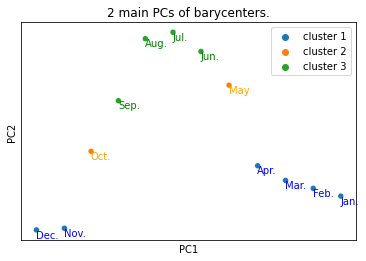

In [7]:
cluster = [["cluster 2", "cluster 1", "cluster 3"][i] for i in [1, 1, 1, 1, 0, 2, 2, 2, 2, 0, 1, 1]]
text = ["Jan.",
        "Feb.",
        "Mar.",
        "Apr.",
        "May",
        "Jun.",
        "Jul.",
        "Aug.",
        "Sep.",
        "Oct.",
        "Nov.",
        "Dec."]
sns.color_palette("tab10")
sns.scatterplot(x=hc_features[:,0]+0.01, y=hc_features[:,1]+0.05, hue=cluster, palette="tab10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2 main PCs of barycenters.")
plt.legend()
for i in range(12) :
    plt.text(x=hc_features[i,0], y=hc_features[i,1], s=text[i], c=["orange","blue","green"][[1, 1, 1, 1, 0, 2, 2, 2, 2, 0, 1, 1][i]])
plt.xticks([])
plt.yticks([])
plt.show()

[1 1 1 1 0 0 0 0 0 0 1 1]
[1 1 1 1 0 2 2 2 2 0 1 1]
[1 1 1 1 2 0 0 0 0 2 3 3]
[1 1 3 3 0 2 2 2 2 0 4 4]
[1 1 4 4 2 5 0 0 5 2 3 3]
[3 3 2 2 6 0 5 5 0 4 1 1]
[2 2 4 4 6 0 5 5 0 3 1 7]
[2 2 8 4 6 0 5 5 0 3 1 7]
[2 9 8 4 6 0 5 5 0 3 1 7]
[ 2  9  8  4  6  0  5  5 10  3  1  7]


<AxesSubplot:xlabel='Value of k', ylabel='Silhouette score'>

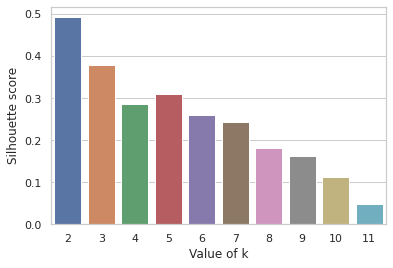

In [56]:
def eval_clustering(barycenters):
    column_except_month_cluster = np.array(barycenters.columns)
    column_except_month_cluster = column_except_month_cluster[column_except_month_cluster != 'month']
    silhouette_result = []
    ch_score_result = []
    for k in range(2,12):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(barycenters[column_except_month_cluster])
        print(kmeans.labels_)

        barycenters['cluster'] = kmeans.labels_

        silhouette = silhouette_score(barycenters[column_except_month_cluster], barycenters['cluster'])
        silhouette_result.append(silhouette)
        ch_score = calinski_harabasz_score(barycenters[column_except_month_cluster], barycenters['cluster'])
        ch_score_result.append(ch_score)

    return silhouette_result, ch_score_result

k_values = np.arange(2,12)
silhouette_result, ch_score_result = eval_clustering(barycenters)

silhouette_data_to_show = pd.DataFrame({'Value of k' : k_values, 'Silhouette score' : silhouette_result})
ch_score_data_to_show = pd.DataFrame({'Value of k' : k_values, 'C-H score' : ch_score_result})

sns.set_theme(style="whitegrid")
sns.barplot(x="Value of k", y="Silhouette score", data=silhouette_data_to_show)

# sns.barplot(x="Value of k", y="C-H score", data=ch_score_data_to_show)

**Petit dataset**
- Avec normalisation
Cluster 1 : Janvier Mars Avril
Cluster 2 : Février Novembre Décembre
Cluster 3 : Mai Août Octobre
Cluster 4 : Juin Juillet Septembre
```{1: 0, 2: 3, 3: 0, 4: 0, 5: 2, 6: 1, 7: 1, 8: 2, 9: 1, 10: 2, 11: 3, 12: 3}```

- Sans normalisation
Cluster 1 : Janvier Février Mars Avril Mai Octobre Novembre Décembre
Cluster 2 : Juin Juillet Août Septembre
```{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1}```

Gros dataset :
no norm [2 2 2 1 0 0 0 0 0 0 2 0]
Cluster 1 : Janvier Février Mars Novembre
Cluster 2 : Avril
Cluster 3 : Mai Juin Juillet Août Septembre Octobre Décembre
```{1: 2, 2: 2, 3: 2, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 2, 12: 0}```

norm [1 1 1 1 0 0 0 0 0 0 1 1]
Cluster 1 : Janvier Février Mars Avril Novembre Décembre
Cluster 2 : Mai Juin Juillet Août Septembre Octobre
```{1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1}```


In [60]:
dico = dict()
# values = [0, 3, 0, 0, 2, 1, 1, 2, 1, 2, 3, 3] # petit dataset normalisé
# values = [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1] # petit dataset non normalisé
# values = [2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0] # gros dataset non normalisé
values = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1] # gros dataset normalisé

for i in range(12):
    dico[i+1] = values[i]

print(dico)

{1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 1}


In [37]:
filename = f"./results/" + dataset + adaptation + algo + ".pklz"
f = gzip.open(filename, "wb")
pickle.dump(results, f)
f.close()

def get_degradation_rates(path, cluster):
    with open(path, 'rb') as file:
        full_dico = pickle.load(file)
        dico = dict()
        for key in full_dico.keys():
            if key[:len(str(cluster)) + 1] == (str(cluster) + ':'):
                dico[key[len(str(cluster)) + 1:]] = full_dico[key]
    return dico

NameError: name 'dataset' is not defined